In [1]:

# 과제5. gridsearchcv, randomsearch
# 과제6. 앙상블 트리별로 feature importance 비교 
# 과제7. n_components, ratio
# 과제8.  pipline(이건 하지말 것)
# 과제9. 위에 있는 내용 소스하나에 압축할 것 
# PCA + feature importance > 앙상블 


In [36]:
import numpy as np
from sklearn.datasets import load_boston,load_diabetes
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV ,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from random import randint
from sklearn.pipeline import Pipeline


In [58]:
 # x, y 가져옴
# 파라미터 x :boston / 1 : diabetes
def data(x):
    import seaborn as sns
    import pandas as pd
    if int(x) == 1:
        data = load_diabetes()
    else:
        data = load_boston()

    col = data.feature_names
    df = pd.DataFrame(data.data, columns=col)
    df['TARGET'] = data.target
    # 히트맵
    # plt.figure(figsize=(13,10))
    # g = sns.heatmap(df.corr(),annot=True,cmap=plt.cm.gist_heat)

    def plot(df, x1, x2):
        fig, ax = plt.subplots(1, 2)
        sns.regplot(x1, df['TARGET'], df, ax=ax[0], scatter_kws={'alpha': 0.4})
        sns.regplot(x2, df['TARGET'], df, ax=ax[1],
                    scatter_kws={'alpha': 0.4})

    # MEDV 와 가장 상관관계 큰 col
    # 히트맵에서 가장 큰 col 2개 이상치 제거
    if x == 0:
        #boston (468,13) (468,)
        x1, x2 = ['RM', 'LSTAT']
        plot(df, x1, x2)
        df_d = df.drop(df[(df['RM'] < 4) | (df['TARGET'] > 38) | (
            df['RM'] > 8) | ((df['LSTAT'] > 25) & (df['TARGET'] > 18))].index)
    else:
        #diabetes (442,10) (442,)
        x1, x2 = ['bmi', 's5']
        plot(df, x1, x2)
        df_d = df.drop(df[((df['TARGET'] > 320) & (df['s5'] < 0.1)) | ((df['bmi'] < 0) & (
            df['TARGET'] > 240)) | ((df['s5'] > 0.06) & (df['TARGET'] < 160))].index)
    plot(df_d, x1, x2)
    df_d = np.array(df_d)

    return df_d[:, :-1], df_d[:, -1], col


x, y, col = data(0)


TypeError: 'Bunch' object is not callable

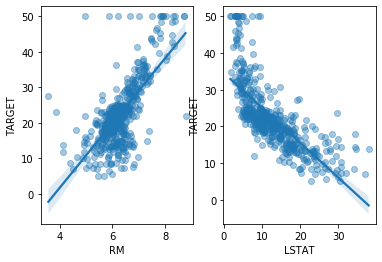

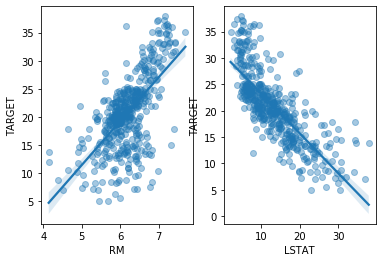

In [48]:
x,y,col = data(data)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [49]:
from sklearn.pipeline import Pipeline 

pipe = Pipeline([
    ('scale',None),#scale에 따라 주성분의 분산이 다를 수 있으므로 왜곡 
    ('pca',None),
    ('regressor',None)
])

In [ ]:
#그리드 서치용
hyperparameter_grid = [
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()],
        'pca' : [PCA(n_components=0.95),None],
        'regressor__n_estimators' : [400,500,600],
        'regressor__max_depth': [30,40,50],
        'regressor__min_samples_split': [2,3,5,8]
    },
    {
        'regressor' : [GradientBoostingRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()],
        'pca' : [PCA(n_components=0.95),None],
        'regressor__n_estimators' : [i for i in range(100,600,100)],
        'regressor__learning_rate': [0.001,0.01,0.1],
        'regressor__max_depth': [2,3,5]
    },
     {
        'regressor' : [lgb.LGBMRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()],
        'pca' : [PCA(n_components=0.95),None],
        'regressor__n_estimators' : [i for i in range(100,600,100)],
        'regressor__learning_rate': [0.001,0.01,0.1],
        'regressor__max_depth': [5,-1]
    },
    {
        'regressor' : [XGBRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()],
        'pca' : [PCA(n_components=0.95),None],
        'regressor__n_estimators' : [i for i in range(100,600,100)],
        'regressor__learning_rate': [0.05,0.1],
        'regressor__num_iterations ': [400,700,1000],
        'regressor__max_depth': [5,10,15,-1],
        'regressor__booster': ['gblinear','gbtree','dart'] 
    }
]


grid = GridSearchCV(pipe,hyperparameter_grid,scoring='neg_mean_squared_error',verbose=2, cv=3,n_jobs=5)
grid.fit(x_train,y_train)



Fitting 3 folds for each of 2826 candidates, totalling 8478 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.6min


In [ ]:
 
print(f'best params : {grid.best_params_ }',
      f'test score : {grid.best_estimator_.score(x_test,y_test).round(3)}',sep='\n'
     ) 
'''
BOSTON DATA

best params : {'pca': None, 'regressor': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'regressor__learning_rate': 0.1, 'regressor__max_depth': -1, 'regressor__n_estimators': 200, 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)}
test score : 0.893
'''

In [ ]:
#RANDOMSEARCH는 PCA 없이 해서 FEATURE IMPORTANCE 볼 것

In [55]:
random_grid = [
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()], 
        'regressor__n_estimators' : [randint(400,800)],
        'regressor__max_depth': [30,40,50],
        'regressor__min_samples_split': [2,3,5,8]
    },
    {
        'regressor' : [GradientBoostingRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()], 
        'regressor__n_estimators' : [randint(400,800)],
        'regressor__learning_rate': [0.001,0.01,0.1],
        'regressor__max_depth': [2,3,5]
    },
     {
        'regressor' : [lgb.LGBMRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()], 
        'regressor__n_estimators' : [randint(100,800)],
        'regressor__learning_rate': [0.001,0.01,0.1],
        'regressor__max_depth': [5,-1]
    },
    {
        'regressor' : [XGBRegressor(random_state=42)],
        'scale' : [StandardScaler(), MinMaxScaler(),RobustScaler()], 
        'regressor__n_estimators' : [randint(100,800)],
        'regressor__learning_rate': [0.05,0.1],
        'regressor__num_iterations ': [400,700,1000], 
        'regressor__booster': ['gblinear','gbtree','dart'] 
    }
]

rand = RandomizedSearchCV(pipe,random_grid,scoring='neg_mean_squared_error',n_iter=20,verbose=2, cv=3,n_jobs=-1)
rand.fit(x_train,y_train)
   
# print(f'best params : {rand.best_params_ }',
#       f'test score : {rand.best_estimator_.score(x_test,y_test).round(3)}',sep='\n'
#      )   
'''
best params : {'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor__n_estimators': 794, 'regressor__max_depth': -1, 'regressor__learning_rate': 0.01, 'regressor': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=794, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)}
test score : 0.899
'''

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
C:\Users\ILIFO-006\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best params : {'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor__n_estimators': 794, 'regressor__max_depth': -1, 'regressor__learning_rate': 0.01, 'regressor': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=794, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)}
test score : 0.899


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   11.8s finished


"\nbest params : {'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,\n             with_scaling=True), 'regressor__n_estimators': 264, 'regressor__max_depth': -1, 'regressor__learning_rate': 0.1, 'regressor': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n              importance_type='split', learning_rate=0.1, max_depth=-1,\n              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,\n              n_estimators=264, n_jobs=-1, num_leaves=31, objective=None,\n              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,\n              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)}\ntest score : 0.892\n"

In [53]:

# from pprint import pprint
# lg = XGBRegressor(random_state=42)
# pprint(lg.get_params())

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


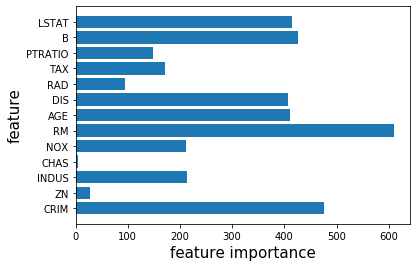

In [57]:

def feature(model , col): 
    plt.barh(np.arange(len(col)), best.named_steps["regressor"].feature_importances_, align='center')
    plt.yticks(np.arange(len(col)), col)
    plt.ylim(-1, len(col))
    plt.xlabel('feature importance', size=15)
    plt.ylabel('feature', size=15)
    plt.show()

feature(rand , col)
